In [35]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
import scipy.io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense ,Input, Lambda, Dropout,Conv2D,BatchNormalization,Activation,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img

In [36]:
img_size = 224 
batch_size = 64  

train_datagen = ImageDataGenerator(
    rescale=1./255,    
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
train_generator = train_datagen.flow_from_directory(
    'dataset/train/',  # This is the source directory for training images
    batch_size=batch_size,
    target_size=(img_size, img_size),
    class_mode='categorical',
    
)

validation_generator = test_datagen.flow_from_directory(
    'dataset/test/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)


Found 11397 images belonging to 5 classes.
Found 2851 images belonging to 5 classes.


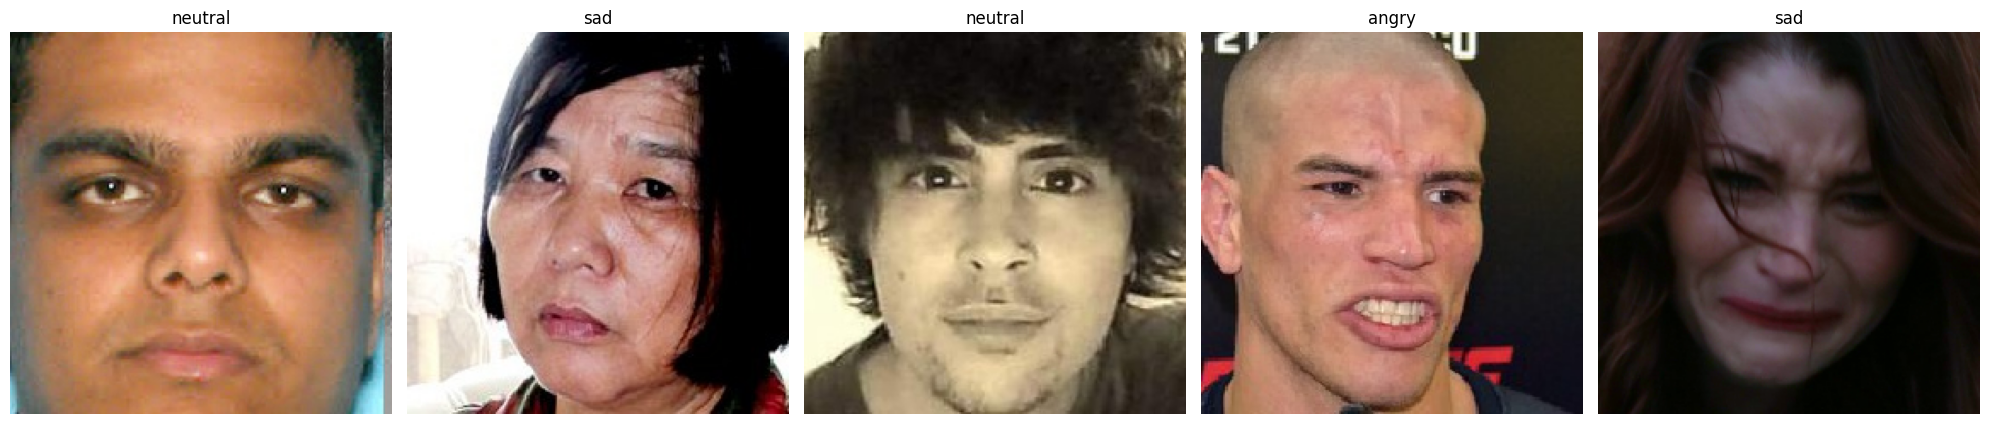

In [39]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

for i in range(num_images):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')
    
    label_index = labels[i].argmax()
    label = idx_to_class[label_index]
    
    ax.set_title(label)

plt.tight_layout()
plt.show()


In [40]:
model = tf.keras.applications.MobileNetV2()

In [41]:
for layer in model.layers:
    layer.trainable= False

In [42]:
base_input = model.layers[0].input
base_output = model.layers[-2].output

In [51]:
final_model = Dense(64)(base_output)
final_model = Activation("relu")(final_model)
final_model = Dense(32)(final_model)
final_model = Activation("relu")(final_model)
final_model = Dense(16)(final_model)
final_model = Activation("relu")(final_model)
final_model = Dense(5,activation='softmax')(final_model)

In [52]:
new_model = Model(inputs= base_input,outputs = final_model)

In [60]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [55]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [56]:
early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'model_checkpoint.h5',  
    monitor='val_loss',
    verbose=1,
    save_best_only=True,  
    mode='min'
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,  # New learning rate = factor * old learning rate
    patience=2,
    min_lr=0.00001
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [57]:
new_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_scheduler, early_stopper,checkpoint, tensorboard_callback] 
)

C:\Users\Feridyan\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.2789 - accuracy: 0.4578
Epoch 00001: val_loss improved from inf to 1.23237, saving model to model_checkpoint.h5
178/178 [==============================] - 83s 457ms/step - loss: 1.2789 - accuracy: 0.4578 - val_loss: 1.2324 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.5566
Epoch 00002: val_loss improved from 1.23237 to 1.12635, saving model to model_checkpoint.h5
178/178 [==============================] - 41s 231ms/step - loss: 1.0918 - accuracy: 0.5566 - val_loss: 1.1264 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.5906
Epoch 00003: val_loss improved from 1.12635 to 1.04390, saving model to model_checkpoint.h5
178/178 [==============================] - 41s 230ms/step - loss: 1.0090 - accuracy: 0.5906 - val_loss: 1.0439 - val_accuracy: 0.5788 - lr: 0.0

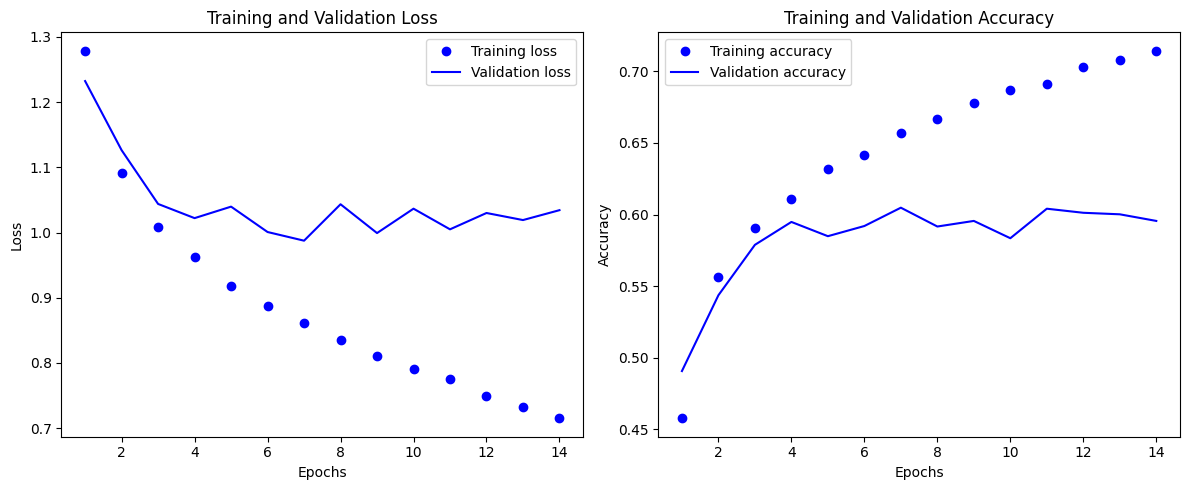

In [59]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the `fit` method of your model
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1) # (rows, columns, subplot index)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
emotion_labels = {
    0: 'angry',
    1: 'happy',
    2: 'neutral',
    3: 'sad',
    4: 'surprise'
}

In [67]:
frame = cv2.imread('p_razi.jpg')
resized_frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
normalized_frame = gray_frame / 255.0
# Convert grayscale to 3-channel RGB
three_channel_frame = np.stack((normalized_frame,)*3, axis=-1)
reshaped_frame = np.reshape(three_channel_frame, (1, 224, 224, 3))

prediction = new_model.predict(reshaped_frame)
emotion_index = np.argmax(prediction)
emotion_index

2

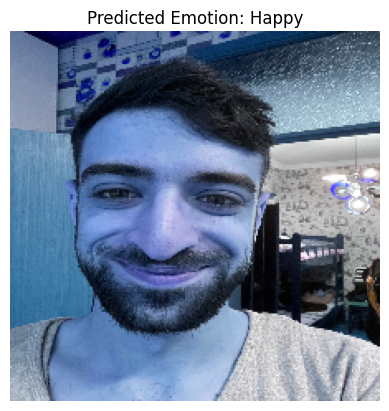

In [70]:
frame = cv2.imread('happy_razi.jpg')
resized_frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
normalized_frame = gray_frame / 255.0
# Convert grayscale to 3-channel RGB
three_channel_frame = np.stack((normalized_frame,)*3, axis=-1)
reshaped_frame = np.reshape(three_channel_frame, (1, 224, 224, 3))

prediction = new_model.predict(reshaped_frame)
emotion_index = np.argmax(prediction)


import matplotlib.pyplot as plt

# Define a list of emotion labels corresponding to the indices of your model's output
emotion_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Use Matplotlib to display the image and the predicted emotion
plt.imshow(resized_frame)  # Show the resized frame (not the grayscale one)
plt.title(f'Predicted Emotion: {emotion_labels[emotion_index]}')
plt.axis('off')  # Hide the axes
plt.show()

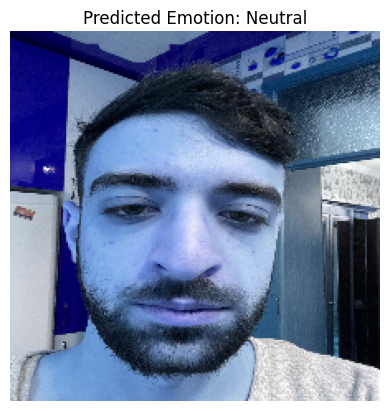

In [68]:
import matplotlib.pyplot as plt

# Define a list of emotion labels corresponding to the indices of your model's output
emotion_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Use Matplotlib to display the image and the predicted emotion
plt.imshow(resized_frame)  # Show the resized frame (not the grayscale one)
plt.title(f'Predicted Emotion: {emotion_labels[emotion_index]}')
plt.axis('off')  # Hide the axes
plt.show()


In [18]:
import cv2
import numpy as np

emotion_labels = {
    0: cv2.imread('angry.png', -1),
    1: cv2.imread('disgust.png', -1),
    2: cv2.imread('fear.png', -1),
    3: cv2.imread('happy.png', -1),
    4: cv2.imread('sad.png', -1),
    5: cv2.imread('surprise.png', -1),
    6: cv2.imread('neutral.png', -1)  
}


cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()

    if ret:
        resized_frame = cv2.resize(frame, (48, 48))
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
        normalized_frame = gray_frame / 255.0
        reshaped_frame = np.reshape(normalized_frame, (1, 48, 48, 1))

       
        prediction = model.predict(reshaped_frame)
        emotion_index = np.argmax(prediction)
        emotion_image = emotion_labels[emotion_index]

       
        emoji_size = 100  
        emoji_image = cv2.resize(emotion_image, (emoji_size, emoji_size))

        
        overlay = np.zeros((frame.shape[0], frame.shape[1], 4), dtype='uint8')
        overlay[10:10+emoji_size, 10:10+emoji_size] = emoji_image  # Adjust location as needed

       
        alpha_mask = overlay[:, :, 3] / 255.0
        for c in range(0, 3):
            frame[10:10+emoji_size, 10:10+emoji_size, c] = (1 - alpha_mask) * frame[10:10+emoji_size, 10:10+emoji_size, c] + alpha_mask * overlay[10:10+emoji_size, 10:10+emoji_size, c]

        
        cv2.imshow('Emotion Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 